#Importing Libraries 

In [1]:
%cd "/content/drive/MyDrive/Sentiment Analysis"

/content/drive/MyDrive/Sentiment Analysis


In [3]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Importing Dataset

In [4]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

path = "/content/drive/MyDrive/Sentiment Analysis/dataset.csv"

df = pd.read_csv(path,encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
#Droping the unuseful columns 

df = df [['sentiment','text']]
df['sentiment'] = df['sentiment'].replace(4,1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# Data Visualisation and Pre Processing the DATA

In [6]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [7]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip() 
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [8]:
df.text = df.text.apply(lambda x: preprocess(x))

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

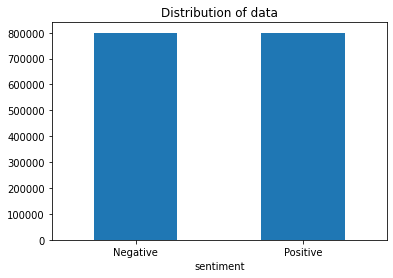

In [9]:
# Plotting the distribution for dataset.


ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)


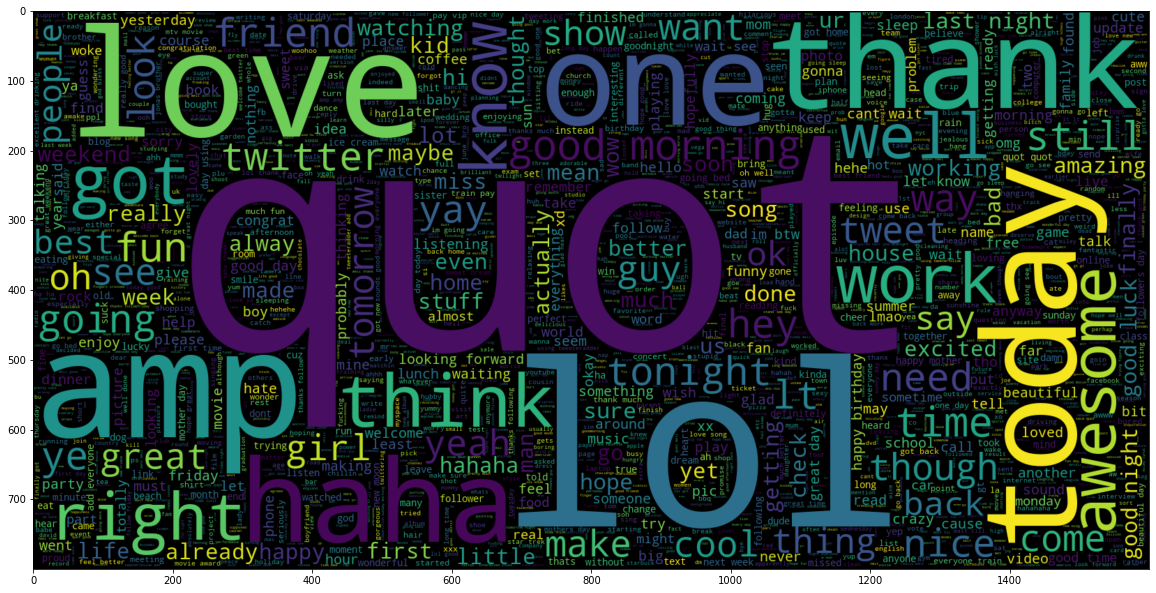

In [10]:
## Wordcloud for Positive Tweets

from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1 ].text))
plt.imshow(wc , interpolation = 'bilinear')

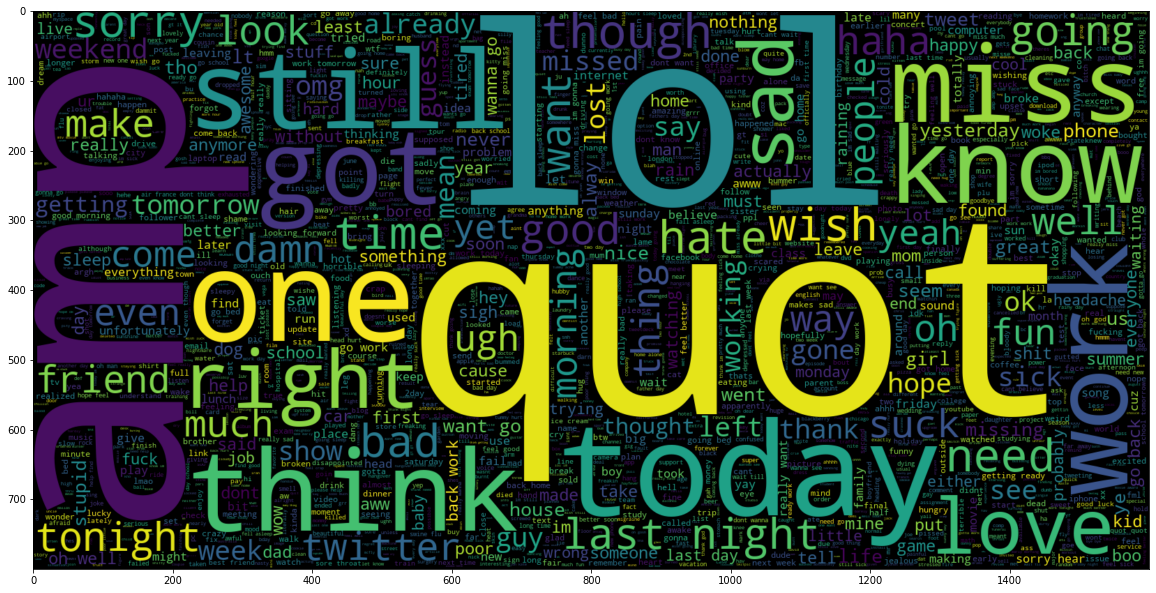

In [11]:

## WordCloud for negative Tweets

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0 ].text))
plt.imshow(wc , interpolation = 'bilinear')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"],test_size = 0.05, random_state = 0)

X_test,X_vald,y_test,y_vald = train_test_split(X_test,y_test ,test_size = 0.4, random_state = 0)

print("length of Train data:", len(X_train))
print("length of Test data:", len(X_test))
print("length of Validation data:", len(X_vald))
print(f'Data Split done.')

length of Train data: 1520000
length of Test data: 48000
length of Validation data: 32000
Data Split done.


In [14]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [15]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


#Training and Evaluating the model

In [16]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
def model_Evaluate(model,X,y):
    
    # Predict values for Test datase
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     24084
           1       0.79      0.81      0.80     23916

    accuracy                           0.80     48000
   macro avg       0.80      0.80      0.80     48000
weighted avg       0.80      0.80      0.80     48000



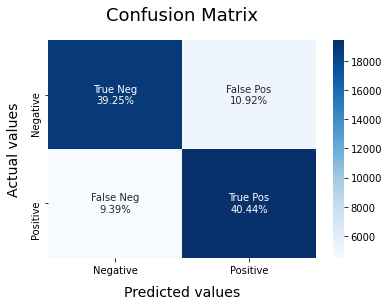

In [24]:
model_Evaluate(LRmodel,X_test,y_test)

#Making prediction

In [19]:
def make_pred(texts,model,thresold):
  # preprocessing the text
  prep =[preprocess(text) for text in texts]
  transformed = vectoriser.transform(prep)

  # Making Prediction
  predict = model.predict(transformed)
  prob = model.predict_proba(transformed)               #array containing the Confidence Score 
  labels = []
  for i in range(len(predict)):
    temp_pred = predict[i]
    temp_prob = prob[i]

  # Labeling Prediction Neutral if Confidence Score is less than a given Thresold

    conf = temp_prob[temp_pred]
    if conf <= thresold:
      label = "Neutral"
    else:
      if temp_pred == 0:
        label = "Negative"
      elif temp_pred == 1:
        label = "Positive"
    labels.append(label)

  return labels


In [20]:
thresold = 0.6

pred = make_pred(X_vald,LRmodel,thresold)


In [22]:
y_vald.value_counts()

1    16095
0    15905
Name: sentiment, dtype: int64

In [21]:
pred = pd.DataFrame(pred)
pred[0].value_counts()

Positive    14293
Negative    13154
Neutral      4553
Name: 0, dtype: int64